# Apply MDM and QDM to CMIP6 daily temperatures
- Daily temperature data is loaded using the OSDF protocol and discovered using an intake-ESM catalog
- We apply three different bias-correction techniques to pairs of CMIP6 models, treating one of the models in the pair as pseudo-observations
- The bias-correction techniques are Moment Delta Mapping, Quantile Delta Mapping+ sort and a shift in DMT

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask_jobqueue
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
import xarray_regrid 
#import seaborn as sns
import s3fs
import cftime
import pandas as pd

/glade/derecho/scratch/harshah/tmp/ipykernel_862/417568950.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
# Decide whether to re-calculate everything
RECALC = False
#
pi_year  = 1865
eoc_year = 2085
#
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
# catalog_url = rda_url +  'harshah/intake_catalogs/osdf/cmip6-aws/cmip6-osdf-zarr.json'
catalog_url = 'https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34653 instead
  warnings.warn(


In [5]:
# Create the client to load the Dashboard
client = Client(cluster)

In [6]:
n_workers =8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(9a136b64, 'tcp://128.117.208.97:37405', workers=8, threads=8, memory=64.00 GiB)

In [7]:
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

def detrend_data(ds, central_year):
    # Assumes that the ds has coordinates day, year and member.
    
    #Fit a linear fuction and extract slope
    pcoeffs = ds.polyfit(dim='year',deg=1)
    slope   = pcoeffs.polyfit_coefficients.sel(degree=1)
    
    #Calculate trend
    ds_trend   = slope*(ds['year']- central_year)
    
    #Detrend by subtracting the trend from the data
    ds_detrended = ds  - ds_trend
    
    return ds_detrended

## Section 2: Load Data

In [8]:
col = intake.open_esm_datastore(catalog_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [9]:
var_name    = 'tas'
folder_path = tmean_path
variable    = ['tas'] #Other variables of interest: 'tasmax', 'tasmin'

In [10]:
# 2. Search for daily temperature 
expts = ['ssp370','historical']

query = dict(
    experiment_id=expts,
    table_id='day',
    variable_id= variable,
    member_id = 'r1i1p1f1',
    #activity_id = 'CMIP',
    
)

col_subset = col.search(require_all_on=["source_id"], **query)

col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id","member_id"]].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-CM2,2,1,1,1
AWI-CM-1-1-MR,2,1,1,1
BCC-CSM2-MR,2,1,1,1
BCC-ESM1,2,1,1,1
CESM2-WACCM,2,1,1,1
CMCC-CM2-SR5,2,1,1,1
CMCC-ESM2,2,1,1,1
CanESM5,2,1,1,1
EC-Earth3,2,1,1,1


In [11]:
df = col_subset.df
# model_counts = df.groupby('source_id').size()
# print(model_counts)
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,day,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...,NaN,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,day,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20191108
2,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,day,tas,gn,s3://cmip6-pds/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/hi...,NaN,20181218
3,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp370,r1i1p1f1,day,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/AWI/AWI-CM-1-...,NaN,20190529
4,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tas,gn,s3://cmip6-pds/CMIP6/CMIP/BCC/BCC-CSM2-MR/hist...,NaN,20181126


In [12]:
df['activity_id'].unique()

array(['CMIP', 'ScenarioMIP', 'AerChemMIP'], dtype=object)

In [13]:
# Keep only rows with CMIP (historical) or ScenarioMIP (ssp370) for consistency. 
df_filtered = col_subset.df[col_subset.df['activity_id'].isin(['CMIP', 'ScenarioMIP'])]

print("Filtered DataFrame shape:", df_filtered.shape)
# print("Filtered activity_id values:", df_filtered['activity_id'])

Filtered DataFrame shape: (53, 11)


In [15]:
df_filtered.groupby("source_id")[["experiment_id", "variable_id", "table_id","activity_id"]].nunique()

,experiment_id,variable_id,table_id,activity_id
source_id,,,,
ACCESS-CM2,2,1,1,2
AWI-CM-1-1-MR,2,1,1,2
BCC-CSM2-MR,2,1,1,2
BCC-ESM1,1,1,1,1
CESM2-WACCM,2,1,1,2
CMCC-CM2-SR5,2,1,1,2
CMCC-ESM2,2,1,1,2
CanESM5,2,1,1,2
EC-Earth3,2,1,1,2


In [15]:
%%time
dsets = col_subset.to_dataset_dict(storage_options={'anon': 'True'})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



Dataset dictionary keys:
 dict_keys(['ScenarioMIP.NCC.NorESM2-LM.ssp370.day.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.day.gr', 'CMIP.BCC.BCC-CSM2-MR.historical.day.gn', 'ScenarioMIP.BCC.BCC-CSM2-MR.ssp370.day.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.day.gr', 'ScenarioMIP.CMCC.CMCC-ESM2.ssp370.day.gn', 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3-AerChem.ssp370.day.gr', 'ScenarioMIP.NCC.NorESM2-MM.ssp370.day.gn', 'CMIP.MIROC.MIROC6.historical.day.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.day.gr', 'ScenarioMIP.INM.INM-CM4-8.ssp370.day.gr1', 'CMIP.AWI.AWI-CM-1-1-MR.historical.day.gn', 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp370.day.gr', 'ScenarioMIP.MIROC.MIROC6.ssp370.day.gn', 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.day.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.day.gn', 'ScenarioMIP.CAS.FGOALS-g3.ssp370.day.gn', 'CMIP.INM.INM-CM5-0.historical.day.gr1', 'CMIP.MRI.MRI-ESM2-0.historical.day.gn', 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn', 'CMIP.IN

In [16]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop_vars(drop_vars)

def open_dset(df):
    assert len(df) == 1
    
    # Force anonymous access for public datasets
    storage_options = {'anon': True}
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0], **storage_options),consolidated=True) #For s3fs protocol
    #ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True) #Use for PelicanFS
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [17]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 3.32 s, sys: 138 ms, total: 3.46 s
Wall time: 8.28 s


In [18]:
#Define coarse grid to regrid on 1 *1 degree card
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1)),
                    'lon': (['lon'], np.arange(0, 361, 1))})
ds_out

<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon      (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359 360
Data variables:
    *empty*

In [19]:
def drop_feb29(ds):
    # Check if the dataset's calendar is not '360_day'
    calendar = ds.time.encoding.get('calendar', None)
    print(ds.attrs['source_id'],calendar)
    if calendar != '360_day':
        ds = ds.convert_calendar('365_day')
    return ds


def to_daily(ds):
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        pass
    elif isinstance(ds['time'].values[0], cftime.datetime):
        pass
    else:
        # convert time coordinate to datetime64 objects
        ds['time'] = ds['time'].astype('datetime64[ns]')
    year      = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  


def extract_data(ds):
    """
    Extract data from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset

    Returns:
    - xarray.Dataset: Dataset subsetted for required years and the specified space and time range.
    """    

    subset1 = ds.sel(year=slice(1850, 1879))
    subset2 = ds.sel(year=slice(2071, 2100))
    
    subset = xr.concat([subset1, subset2], dim='year')  

    return subset

def is_leap(year):
    """Check if a year is a leap year."""
    return (year % 4 == 0) and ((year % 100 != 0) or (year % 400 == 0))


In [20]:
quants = np.linspace(0,1.0,30)

def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def regrid(ds, ds_out):
    experiment_id = ds.attrs['experiment_id']
    source_id     = ds.attrs['source_id']
    ds_new   = ds.regrid.nearest(ds_out)
    
#     #Assign back attributes as regirdder would have deleted attributes 
    ds_new.attrs['experiment_id'] = experiment_id
    ds_new.attrs['source_id'] = source_id
    
    #print(ds_new.attrs['experiment_id'],ds_new.attrs['source_id'])
    #print(ds_new)
    return ds_new

def process_data(ds, quantiles=quants):
    ds = ds.pipe(drop_feb29).pipe(to_daily).pipe(extract_data)
    
    if len(ds['year']) == 0:
        print("The dataset is empty. Skipping...")
        return None
    
    if len(ds['dayofyear'])<365:
        print('The dataset has less than 365 days. Skipping ..')
        return None
    
    # # Remove 'time' coordinate
    # ds = ds.set_index(time=("year", "dayofyear")).unstack("time")  
    return (ds.pipe(regrid, ds_out=ds_out))

## Section 3: Computations. 
- Evalulate these 

In [21]:
%%time
if RECALC:
    with progress.ProgressBar():
    
        expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                               coords={'experiment_id': expts})
    
        # Initialize an Empty Dictionary for Aligned Datasets:
        dsets_aligned = {}
    
        # Iterate Over dsets_ Dictionary:
    
        for k, v in tqdm(dsets_.items()):
            # Initialize a dictionary for this source_id
            dsets_aligned[k] = {}
            
            skip_source_id = False
    
            for expt in expts:
                ds = v[expt].pipe(process_data)
    
                # Check if the dataset is empty and skip this source_id if so
                if ds is None:
                    print(f"Skipping {expt} for {k} because the dataset is empty")
                    skip_source_id = True
                    break
                
                # Store the dataset in the dictionary
                # dsets_aligned[k][expt] = ds
                # Compute the dataset and store it in the dictionary
                dsets_aligned[k][expt] = ds.compute()
                print(dsets_aligned[k][expt])
    
            if skip_source_id:
                del dsets_aligned[k]
                continue

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs


In [22]:
# dsets_aligned.keys()

In [23]:
%%time
if RECALC:
    source_ids = list(dsets_aligned.keys())
    source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})
    final_ds_pi = xr.concat([ds['historical'].reset_coords(drop=True)
                                     for ds in dsets_aligned.values()],
                                    dim=source_da)
    
    final_ds_eoc = xr.concat([ds['ssp370'].reset_coords(drop=True)
                                 for ds in dsets_aligned.values()],
                                dim=source_da)
    final_ds_eoc

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.29 μs


In [24]:
# %%time
# final_ds_pi.to_zarr(folder_path  +'cmip6_pi_daily.zarr',mode='w')
# final_ds_eoc.to_zarr(folder_path +'cmip6_eoc_daily.zarr',mode='w')

In [25]:
final_ds_pi  = xr.open_zarr(folder_path+'cmip6_pi_daily.zarr')
final_ds_eoc = xr.open_zarr(folder_path+'cmip6_eoc_daily.zarr')
final_ds_pi  = final_ds_pi[var_name]
final_ds_eoc = final_ds_eoc[var_name]
final_ds_eoc

<xarray.DataArray 'tasmin' (source_id: 20, year: 30, dayofyear: 365, lat: 181,
                            lon: 361)> Size: 57GB
dask.array<open_dataset-tasmin, shape=(20, 30, 365, 181, 361), dtype=float32, chunksize=(3, 4, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon        (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * source_id  (source_id) <U17 1kB 'ACCESS-CM2' ... 'NorESM2-MM'
  * year       (year) int64 240B 2071 2072 2073 2074 ... 2097 2098 2099 2100

### Detrend data and save

In [27]:
%%time
ds_pi_det  = detrend_data(final_ds_pi,pi_year)
ds_eoc_det = detrend_data(final_ds_eoc,eoc_year)
ds_eoc_det = ds_eoc_det.chunk({'year':30,'source_id':1})
ds_pi_det = ds_pi_det.chunk({'year':30,'source_id':1})
ds_eoc_det

CPU times: user 737 ms, sys: 6.49 ms, total: 744 ms
Wall time: 789 ms


<xarray.DataArray (source_id: 20, year: 30, dayofyear: 365, lat: 181, lon: 361)> Size: 114GB
dask.array<rechunk-merge, shape=(20, 30, 365, 181, 361), dtype=float64, chunksize=(1, 30, 46, 46, 91), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) int64 1kB -90 -89 -88 -87 -86 -85 -84 ... 85 86 87 88 89 90
  * lon        (lon) int64 3kB 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * source_id  (source_id) <U17 1kB 'ACCESS-CM2' ... 'NorESM2-MM'
  * year       (year) int64 240B 2071 2072 2073 2074 ... 2097 2098 2099 2100
    degree     int64 8B 1

In [29]:
# %%time
# ds_pi_det.rename(var_name).to_dataset().to_zarr(folder_path  +'cmip6_pi_ann_detrended.zarr',mode='w')

In [30]:
# %%time
# ds_eoc_det.rename(var_name).to_dataset().to_zarr(folder_path +'cmip6_eoc_ann_detrended.zarr',mode='w')

### Check if detrending worked

In [31]:
ds_pi_det  = xr.open_zarr(folder_path  +'cmip6_pi_ann_detrended.zarr')
ds_eoc_det = xr.open_zarr(folder_path +'cmip6_eoc_ann_detrended.zarr')
#
ds_pi_det  = ds_pi_det[var_name]
ds_eoc_det = ds_eoc_det[var_name]

CPU times: user 286 ms, sys: 10.1 ms, total: 296 ms
Wall time: 920 ms


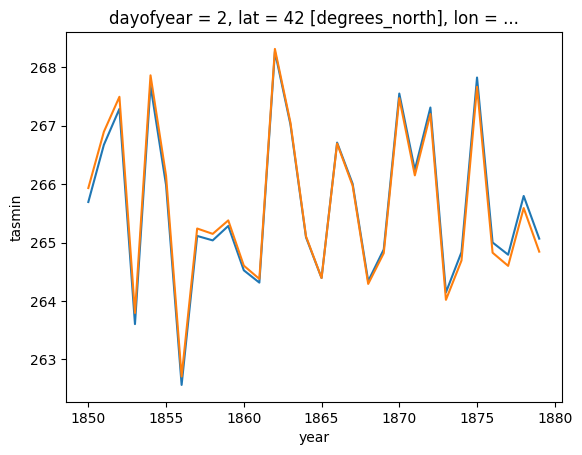

In [36]:
%%time
ds_pi_det.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('source_id').plot()
final_ds_pi.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('source_id').plot()

CPU times: user 273 ms, sys: 6.35 ms, total: 279 ms
Wall time: 937 ms


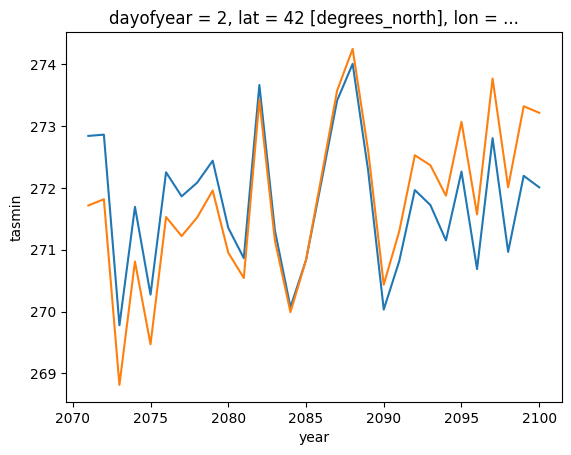

In [37]:
%%time
ds_eoc_det.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('source_id').plot()
final_ds_eoc.sel(lat=chic_lat,lon=chic_lon,method='nearest').sel(dayofyear=2).mean('source_id').plot()